**I think we can start here with preprocessing and building up a pipeline for classifying with a traditional model from pose estimation**

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Classes

- Walking
- Standing
- Fast walking / jogging?
- Running

# Import data from google drive

In [1]:
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=True)

zip_path = '/content/drive/My Drive/hmdb51_stabalized.zip'

extract_path = "/content/hmdb51_data"

if not os.path.exists(extract_path):
    !unzip -q "{zip_path}" -d "{extract_path}"
else:
    print(f"The directory {extract_path} already exists.")

path = extract_path + "/hmdb51_stabalized"

Mounted at /content/drive
The directory /content/hmdb51_data already exists.


# Import libraries and set up configurations

In [2]:
import os
import cv2
import numpy as np
import gc

RAW_DATA_PATH = path
# SAVE TO DRIVE so you never have to do this again
SAVE_PATH = "/content/drive/My Drive/hmdb51_processed"
CLASSES = ["run", "walk", "stand"]
IMG_SIZE = 128
FRAME_COUNT = 16

# Load a process data with cv2 to extract frames

In [3]:
# Create save folder if not exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

def process_video_uint8(path):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()

    if len(frames) == 0: return None

    # Even sampling
    indices = np.linspace(0, len(frames)-1, FRAME_COUNT, dtype=int)
    # KEEP AS UINT8 (Small size)
    return np.array([frames[i] for i in indices], dtype=np.uint8)

print(f" Starting processing. Saving to: {SAVE_PATH}")

 Starting processing. Saving to: /content/drive/My Drive/hmdb51_processed


In [4]:
for class_id, class_name in enumerate(CLASSES):
    print(f"\nProcessing class: '{class_name}'...")
    folder_path = os.path.join(RAW_DATA_PATH, class_name)

    class_videos = []
    class_labels = []

    if not os.path.exists(folder_path):
        print(f"Skipping {class_name} (folder missing)")
        continue

    files = [f for f in os.listdir(folder_path) if f.endswith('.avi')]

    for file_name in files:
        video_path = os.path.join(folder_path, file_name)
        video_data = process_video_uint8(video_path)

        if video_data is not None:
            class_videos.append(video_data)
            class_labels.append(class_id)

    # Convert to array and save IMMEDIATELY
    if len(class_videos) > 0:
        X_chunk = np.array(class_videos, dtype=np.uint8)
        y_chunk = np.array(class_labels, dtype=np.int32)

        # Save to Drive
        np.save(os.path.join(SAVE_PATH, f"X_{class_name}.npy"), X_chunk)
        np.save(os.path.join(SAVE_PATH, f"y_{class_name}.npy"), y_chunk)

        print(f" Saved {class_name}: {X_chunk.shape} samples")

    # FREE RAM
    del class_videos, class_labels, X_chunk, y_chunk
    gc.collect() # Force Python to release memory

print("\n All Processing Complete! Data is safely on Google Drive.")


Processing class: 'run'...
 Saved run: (232, 16, 128, 128, 3) samples

Processing class: 'walk'...
 Saved walk: (548, 16, 128, 128, 3) samples

Processing class: 'stand'...
 Saved stand: (154, 16, 128, 128, 3) samples

 All Processing Complete! Data is safely on Google Drive.


# Train test split, but first loading from drive (I was havinng problems with RAM on colab otherwise)

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Config
DATASET_PATH = path

# We only store the text locations of the files. This is instant and lightweight.
all_video_paths = []
all_labels = []

print("Scanning for file paths...")
for class_id, class_name in enumerate(CLASSES):
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder):
        print(f" Warning: Folder not found: {folder} (Did you forget to Unzip?)")
        continue

    # Find all .avi files
    files = [f for f in os.listdir(folder) if f.endswith('.avi')]
    for f in files:
        all_video_paths.append(os.path.join(folder, f))
        all_labels.append(class_id)

print(f" Found {len(all_video_paths)} videos.")

# We split the list of strings, not the heavy video data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_video_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Train set: {len(train_paths)} paths")
print(f"Validation set: {len(val_paths)} paths")

Scanning for file paths...
 Found 934 videos.
Train set: 747 paths
Validation set: 187 paths


# Model build (pre-trained efficientnet)

In [6]:
import tensorflow as tf
import cv2

class VideoGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size=8, img_size=128, frame_count=16, shuffle=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.indices = np.arange(len(self.paths))
        self.on_epoch_end() # Initialize shuffle

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        # 1. Get the indices for this batch
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        # 2. Setup the empty batch arrays
        X = np.empty((self.batch_size, self.frame_count, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int32)

        # 3. Fill the batch
        for i, idx in enumerate(batch_indices):
            # Read the video file (Disk -> RAM)
            video_path = self.paths[idx]
            frames = self._load_video(video_path)

            X[i] = frames
            y[i] = self.labels[idx]

        # 4. Preprocess for EfficientNet (Scaling)
        return tf.keras.applications.efficientnet.preprocess_input(X), y

    def _load_video(self, path):
      cap = cv2.VideoCapture(path)
      frames = []
      try:
          while True:
              ret, frame = cap.read()
              if not ret:
                  break
              frame = cv2.resize(frame, (self.img_size, self.img_size))
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              frames.append(frame)
      finally:
          cap.release()

      # Handle broken videos
      if len(frames) == 0:
          return np.zeros(
              (self.frame_count, self.img_size, self.img_size, 3),
              dtype=np.float32
          )

      # Temporal jitter
      if len(frames) > self.frame_count:
          start = np.random.randint(0, len(frames) - self.frame_count + 1)
          selected = frames[start:start + self.frame_count]
      else:
          indices = np.linspace(0, len(frames) - 1, self.frame_count, dtype=int)
          selected = [frames[i] for i in indices]

      return np.array(selected)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create the Generators
train_gen = VideoGenerator(train_paths, train_labels, batch_size=8)
val_gen = VideoGenerator(val_paths, val_labels, batch_size=8, shuffle=False)

In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # <<< Add this at the very top, before building the model

from tensorflow.keras import layers, models, applications, optimizers

def build_advanced_model():
    # Input: video sequence
    video_input = layers.Input(shape=(FRAME_COUNT, IMG_SIZE, IMG_SIZE, 3))

    # EfficientNetB0 feature extractor
    base_cnn = applications.EfficientNetB0(
        weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze all layers except top 25
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-25]:
        layer.trainable = False

    # Extract spatial features from each frame
    encoded = layers.TimeDistributed(base_cnn)(video_input)

    # ConvLSTM to model temporal dynamics across feature maps
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=False,
        activation='tanh'
    )(encoded)

    # Global pooling and dropout
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Output layer - keep dtype float32 for stable softmax
    output = layers.Dense(len(CLASSES), activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=video_input, outputs=output)

    # Compile with small learning rate for fine-tuning EfficientNet
    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_advanced_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 4, 4, 1280) │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 4, 4, 64)       │     3,096,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,146,598 (27.26 MB)

 Trainable params: 4,559,779 (17.39 MB)

 Non-trainable params: 2,586,819 (9.87 MB)

# Train the model on our classes

In [17]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

drive.mount('/content/drive')

# This creates a folder "Models" in your Drive if it doesn't exist
save_folder = "/content/drive/MyDrive/Models"
os.makedirs(save_folder, exist_ok=True)
checkpoint_path = os.path.join(save_folder, "hmdb51_efficientnet_best.keras")

print(f" Model will be saved to: {checkpoint_path}")

class_weights_array = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {i: w for i, w in enumerate(class_weights_array)}


# Define Callbacks
callbacks = [
    # Stop if validation loss doesn't improve for 4 epochs
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),

    # Save the model every time the validation loss improves
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1 # Prints a message when saving
    )
]

# Train using the Generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model will be saved to: /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4124 - loss: 1.0620
Epoch 1: val_loss improved from inf to 0.96576, saving model to /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 921s 3s/step - accuracy: 0.4127 - loss: 1.0618 - val_accuracy: 0.5761 - val_loss: 0.9658
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5868 - loss: 0.8466
Epoch 2: val_loss improved from 0.96576 to 0.86612, saving model to /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 536ms/step - accuracy: 0.5868 - loss: 0.8465 - val_accuracy: 0.6304 - val_loss: 0.8661
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6388 - loss: 0.7239
Epoch 3: val_loss improved from 0.86612 to 0.85362, saving model to /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.6389 - loss: 0.7240 - val_accuracy: 0.6087 - val_loss: 0.8536
Epoch 4

# Save the model to google Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive')

!mv /content/hmdb51_efficientnet.keras /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat '/content/hmdb51_efficientnet.keras': No such file or directory


In [8]:
from tensorflow.keras.models import load_model
from google.colab import drive

drive.mount('/content/drive')
model = load_model("/content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 302s 444ms/step
Predictions: (184,)
Ground Truth: (184,)


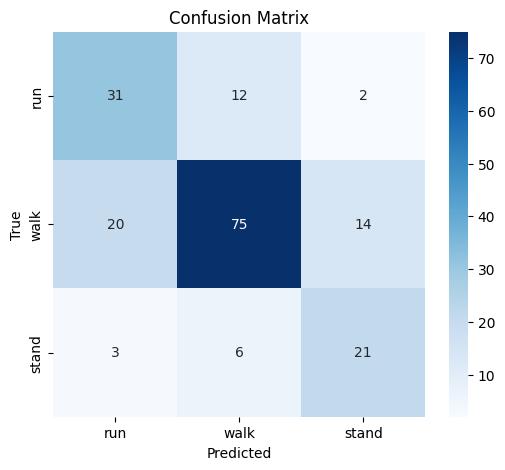


Classification Report:
              precision    recall  f1-score   support

         run       0.57      0.69      0.63        45
        walk       0.81      0.69      0.74       109
       stand       0.57      0.70      0.63        30

    accuracy                           0.69       184
   macro avg       0.65      0.69      0.67       184
weighted avg       0.71      0.69      0.70       184



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


y_pred_prob = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)


y_true = []
for i in range(len(val_gen)):
    _, batch_labels = val_gen[i]
    y_true.extend(batch_labels)

y_true = np.array(y_true)

# Sanity Check: These shapes MUST match
print(f"Predictions: {y_pred.shape}")
print(f"Ground Truth: {y_true.shape}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 4. REPORT
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))


In [10]:
# Get probabilities: shape (N, num_classes)
y_prob = model.predict(val_gen)

# Predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# True labels
y_true = val_gen.labels[:len(y_pred)]


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step


In [11]:
# Model confidence per prediction
confidence = np.max(y_prob, axis=1)

# Correct / incorrect mask
correct = (y_pred == y_true)

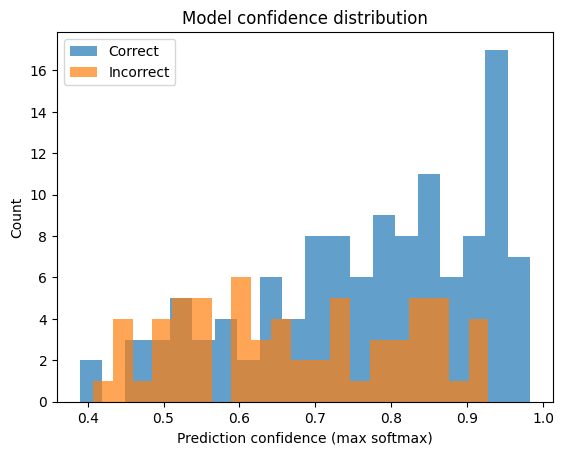

In [12]:
import matplotlib.pyplot as plt

plt.hist(confidence[correct], bins=20, alpha=0.7, label="Correct")
plt.hist(confidence[~correct], bins=20, alpha=0.7, label="Incorrect")
plt.xlabel("Prediction confidence (max softmax)")
plt.ylabel("Count")
plt.legend()
plt.title("Model confidence distribution")
plt.show()

In [13]:
bins = np.linspace(0.5, 1.0, 6)  # 0.5–1.0
bin_ids = np.digitize(confidence, bins)

print("Confidence range | Accuracy | Samples")
print("--------------------------------------")

for i in range(1, len(bins)):
    mask = bin_ids == i
    if np.sum(mask) == 0:
        continue
    acc = np.mean(correct[mask])
    print(f"{bins[i-1]:.2f}–{bins[i]:.2f}        | {acc:.2f}     | {np.sum(mask)}")


Confidence range | Accuracy | Samples
--------------------------------------
0.50–0.60        | 0.50     | 28
0.60–0.70        | 0.56     | 27
0.70–0.80        | 0.71     | 38
0.80–0.90        | 0.67     | 43
0.90–1.00        | 0.88     | 33


In [21]:
num_classes = y_prob.shape[1]
y_true = np.array(y_true)  # now it has .shape

for c in range(num_classes):
    mask = (y_true == c)
    avg_prob = np.mean(y_prob[mask, c])
    print(f"Class {c}: mean predicted probability = {avg_prob:.3f}")

Class 0: mean predicted probability = 0.530
Class 1: mean predicted probability = 0.622
Class 2: mean predicted probability = 0.543


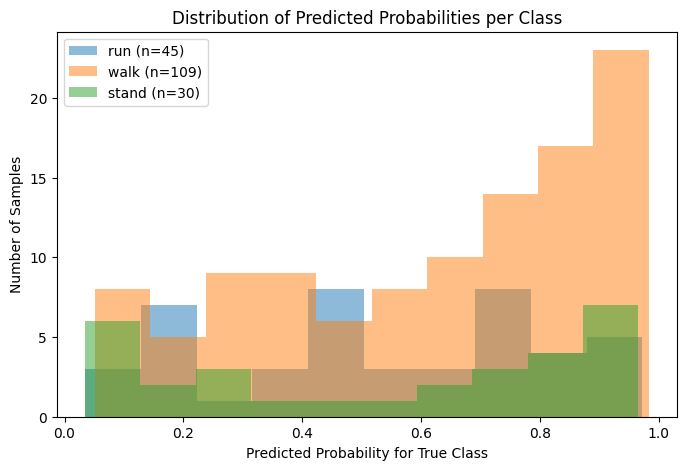

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# y_true: true labels (0,1,2)
# y_prob: predicted probabilities, shape (num_samples, num_classes)

num_classes = y_prob.shape[1]
class_names = ["run", "walk", "stand"]

plt.figure(figsize=(8,5))

for c in range(num_classes):
    # Get predicted probabilities for the true class c
    probs = y_prob[y_true == c, c]
    plt.hist(probs, bins=10, alpha=0.5, label=f"{class_names[c]} (n={len(probs)})")

plt.title("Distribution of Predicted Probabilities per Class")
plt.xlabel("Predicted Probability for True Class")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()
